<a href="https://colab.research.google.com/github/yuukun123/Python/blob/master/Copy_of_Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Tùy chỉnh để hiển thị biểu đồ đẹp hơn
sns.set(style="whitegrid")

In [10]:
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)
df.head()  # Hiển thị 5 dòng đầu tiên



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# df.info()        # Thông tin cột, kiểu dữ liệu
# df.describe()    # Thống kê mô tả
# df.isnull().sum() # Kiểm tra giá trị bị thiếu


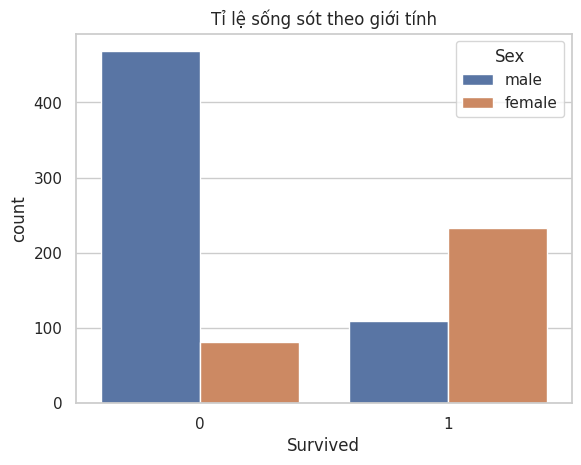

In [9]:
sns.countplot(x="Survived", hue="Sex", data=df)
plt.title("Tỉ lệ sống sót theo giới tính")
plt.show()


In [11]:
survival_rate = df.groupby("Pclass")["Survived"].mean()
print(survival_rate)


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


In [4]:
from google.colab import drive
drive.mount('/content/drive')

df.to_csv('/content/drive/MyDrive/titanic.csv', index=False)

Mounted at /content/drive
